# Basics

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaOptimalTransport/OptimalTransport.jl/blob/master/examples/basic/script.jl).
The rendered HTML can be viewed [in the docs](https://juliaoptimaltransport.github.io/OptimalTransport.jl/dev/examples/basic/).*

## Packages

We load the following packages into our environment:

In [1]:
using OptimalTransport
using Distances
using Plots
using PythonOT: PythonOT
using Tulip

using LinearAlgebra
using Random

Random.seed!(1234)

const POT = PythonOT

PythonOT

## Problem setup

First, let us initialise two random probability measures $\mu$ (source measure)
and $\nu$ (target measure) in 1D:

In [2]:
M = 200
μ = fill(1 / M, M)
μsupport = rand(M)

N = 250
ν = fill(1 / N, N)
νsupport = rand(N);

Now we compute the quadratic cost matrix $C_{ij} = \| x_i - x_j \|_2^2$:

In [3]:
C = pairwise(SqEuclidean(), μsupport', νsupport'; dims=2);

## Exact optimal transport

The **earth mover's distance** is defined as the optimal value of the
Monge-Kantorovich problem
$$
\inf_{\gamma \in \Pi(\mu, \nu)} \langle \gamma, C \rangle =
\inf_{\gamma \in \Pi(\mu, \nu)} \sum_{i, j} \gamma_{ij} C_{ij},
$$
where $\Pi(\mu, \nu)$ denotes the set of couplings of $\mu$ and $\nu$, i.e., the set of joint
distributions whose marginals are $\mu$ and $\nu$.
If $C$ is the quadratic cost matrix, the earth mover's distance is known as the square of
the **2-Wasserstein distance**.

The function `emd` returns the optimal transport *plan* $\gamma$

In [4]:
γ = emd(μ, ν, C, Tulip.Optimizer());

whilst using `emd2` returns the optimal transport *cost*:

In [5]:
emd2(μ, ν, C, Tulip.Optimizer())

0.001487781413491063

## Entropically regularised optimal transport

We may add an entropy term to the Monge-Kantorovich problem to obtain the
**entropically regularised** optimal transport problem
$$
\inf_{\gamma \in \Pi(\mu, \nu)} \langle \gamma, C \rangle + \varepsilon \Omega(\gamma),
$$
where $\Omega(\gamma) = \sum_{i, j} \gamma_{ij} \log(\gamma_{ij})$ is the negative
entropy of the coupling $\gamma$ and $\varepsilon$ controls the strength of the regularisation.

This problem is *strictly convex* and admits a very efficient iterative scaling scheme for
its solution known as the [Sinkhorn algorithm](https://doi.org/10.1214/aoms/1177703591).

We compute the optimal entropically regularised transport plan:

In [6]:
ε = 0.01
γ = sinkhorn(μ, ν, C, ε);

We can check that one obtains the same result with the Python Optimal Transport (POT) package:

In [7]:
γpot = POT.sinkhorn(μ, ν, C, ε)
norm(γ - γpot, Inf)

5.79577190277028e-12

We can compute the optimal cost (a scalar) of the entropically regularized optimal
transport problem with `sinkhorn2`:

In [8]:
sinkhorn2(μ, ν, C, ε)

0.00599172263125863

## Quadratically regularised optimal transport

Instead of the common entropically regularised optimal transport problem, we can solve the
[quadratically regularised optimal transport problem](https://doi.org/10.1007/s00245-019-09614-w)
$$
\inf_{\gamma \in \Pi(\mu, \nu)} \langle \gamma, C \rangle + \varepsilon \frac{\| \gamma \|_F^2}{2}.
$$
One property of the quadratically regularised optimal transport problem is that the
resulting transport plan $\gamma$ is *sparse*. We take advantage of this and represent it as
a sparse matrix.

In [9]:
quadreg(μ, ν, C, ε; maxiter=100);

## Stabilized Sinkhorn algorithm

When $\varepsilon$ is very small, we can use a
[log-stabilised version of the Sinkhorn algorithm](https://doi.org/10.1137/16M1106018).

In [10]:
ε = 0.005
γ = sinkhorn_stabilized(μ, ν, C, ε; maxiter=5_000);

Again we can check that the same result is obtained with the POT package:

In [11]:
γ_pot = POT.sinkhorn(μ, ν, C, ε; method="sinkhorn_stabilized", numItermax=5_000)
norm(γ - γ_pot, Inf)

8.684135875680621e-12

## Stabilized Sinkhorn algorithm with $\varepsilon$-scaling

In addition to log-stabilisation, we can use [$\varepsilon$-scaling](https://doi.org/10.1137/16M1106018):

In [12]:
γ = sinkhorn_stabilized_epsscaling(μ, ν, C, ε; maxiter=5_000);

The POT package yields the same result:

In [13]:
γpot = POT.sinkhorn(μ, ν, C, ε; method="sinkhorn_epsilon_scaling", numItermax=5000)
norm(γ - γpot, Inf)

1.665707020015103e-11

## Unbalanced optimal transport

[Unbalanced optimal transport](https://doi.org/10.1090/mcom/3303) deals with general
positive measures which do not necessarily have the same total mass. For unbalanced
source and target marginals $\mu$ and $\nu$ and a cost matrix $C$, entropically
regularised unbalanced optimal transport solves
$$
\inf_{\gamma \geq 0} \langle \gamma, C \rangle + \varepsilon \Omega(\gamma) + \lambda_1 \mathrm{KL}(\gamma 1 | \mu) + \lambda_2 \mathrm{KL}(\gamma^{\mathsf{T}} 1 | \nu),
$$
where $\varepsilon$ controls the strength of the entropic regularisation, and $\lambda_1$ and
$\lambda_2$ control how strongly we enforce the marginal constraints.

We construct two random measures, now with different total masses:

In [14]:
M = 100
μ = fill(1 / M, M)
μsupport = rand(M)

N = 200
ν = fill(1 / M, N)
νsupport = rand(N);

We compute the quadratic cost matrix:

In [15]:
C = pairwise(SqEuclidean(), μsupport', νsupport'; dims=2);

Now we solve the corresponding unbalanced, entropy-regularised transport problem with
$\varepsilon = 0.01$ and $\lambda_1 = \lambda_2 = 1$:

In [16]:
ε = 0.01
λ = 1
γ = sinkhorn_unbalanced(μ, ν, C, λ, λ, ε);

We check that the result agrees with POT:

In [17]:
γpot = POT.sinkhorn_unbalanced(μ, ν, C, ε, λ)
norm(γ - γpot, Inf)

1.245810654507476e-9

## Plots

### Entropically regularised transport

Let us construct source and target measures again:

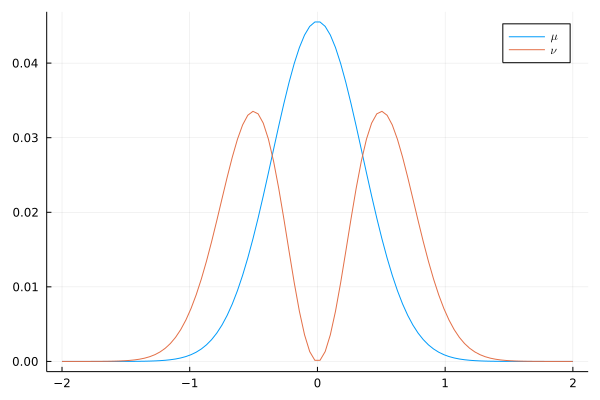

In [18]:
μsupport = νsupport = range(-2, 2; length=100)
C = pairwise(SqEuclidean(), μsupport', νsupport'; dims=2)
μ = normalize!(exp.(-μsupport .^ 2 ./ 0.5^2), 1)
ν = normalize!(νsupport .^ 2 .* exp.(-νsupport .^ 2 ./ 0.5^2), 1)

plot(μsupport, μ; label=raw"$\mu$", size=(600, 400))
plot!(νsupport, ν; label=raw"$\nu$")

Now we compute the entropically regularised transport plan:

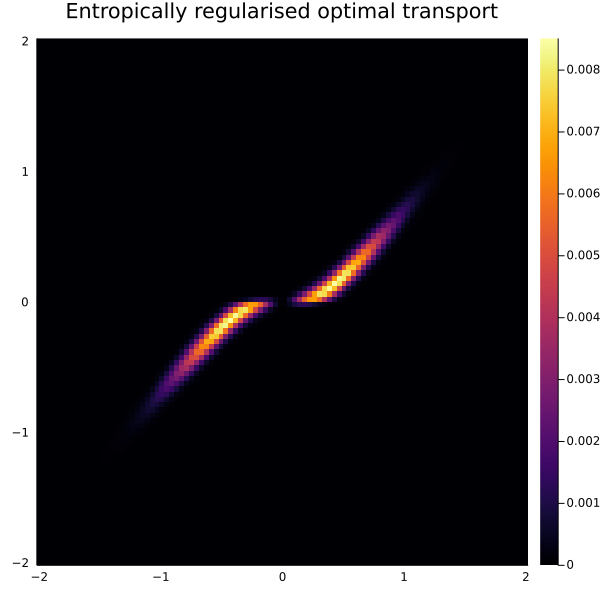

In [19]:
γ = sinkhorn(μ, ν, C, 0.01)
heatmap(
    μsupport,
    νsupport,
    γ;
    title="Entropically regularised optimal transport",
    size=(600, 600),
)

### Quadratically regularised transport

Notice how the "edges" of the transport plan are sharper if we use quadratic regularisation
instead of entropic regularisation:

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/work/OptimalTransport.jl/OptimalTransport.jl/src/quadratic_newton.jl:216


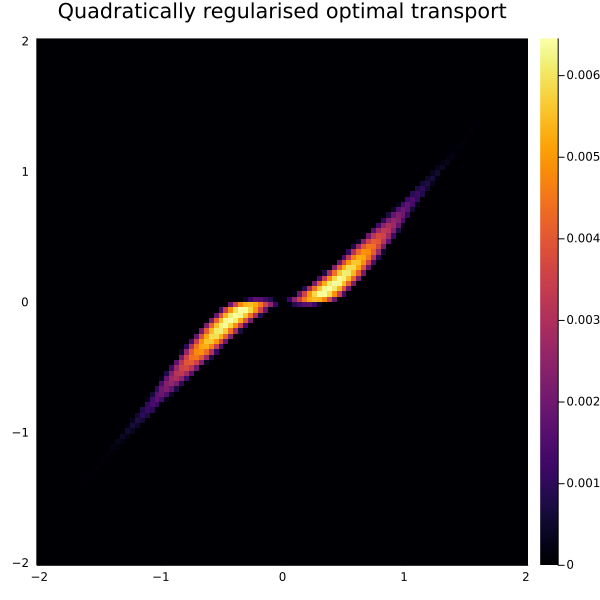

In [20]:
γquad = quadreg(μ, ν, C, 5; maxiter=100);
heatmap(
    μsupport,
    νsupport,
    γquad;
    title="Quadratically regularised optimal transport",
    size=(600, 600),
)

### Sinkhorn barycenters

For a collection of discrete probability measures $\{\mu_i\}_{i=1}^N \subset \mathcal{P}$,
cost matrices $\{C_i\}_{i=1}^N$, and positive weights $\{\lambda_i\}_{i=1}^N$ summing to $1$,
the entropically regularised **barycenter** in $\mathcal{P}$ is the discrete probability
measure $\mu$ that solves
$$
\inf_{\mu \in \mathcal{P}} \sum_{i = 1}^N \lambda_i \operatorname{OT}_{\varepsilon}(\mu, \mu_i)
$$
where $\operatorname{OT}_\varepsilon(\mu, \mu_i)$ denotes the entropically regularised
optimal transport cost with marginals $\mu$ and $\mu_i$, cost matrix $C$, and entropic
regularisation parameter $\varepsilon$.

We set up two measures and compute the weighted barycenters. We choose weights
$\lambda_1 \in \{0.25, 0.5, 0.75\}$.

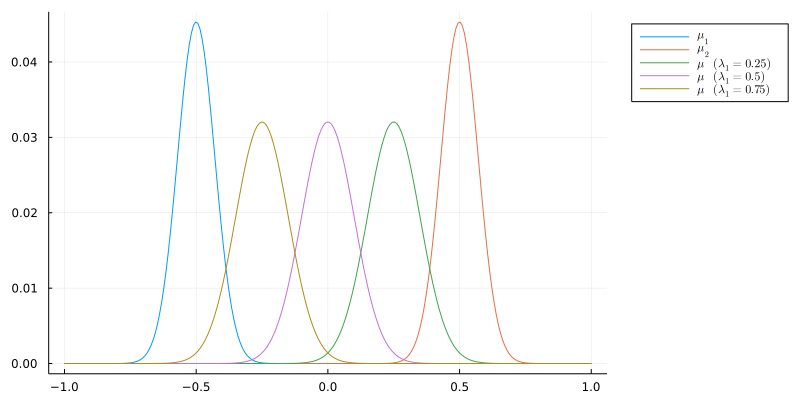

In [21]:
support = range(-1, 1; length=250)
mu1 = normalize!(exp.(-(support .+ 0.5) .^ 2 ./ 0.1^2), 1)
mu2 = normalize!(exp.(-(support .- 0.5) .^ 2 ./ 0.1^2), 1)

plt = plot(; size=(800, 400), legend=:outertopright)
plot!(plt, support, mu1; label=raw"$\mu_1$")
plot!(plt, support, mu2; label=raw"$\mu_2$")

mu = hcat(mu1, mu2)
C = pairwise(SqEuclidean(), support'; dims=2)
for λ1 in (0.25, 0.5, 0.75)
    λ2 = 1 - λ1
    a = sinkhorn_barycenter(mu, C, 0.01, [λ1, λ2], SinkhornGibbs())
    plot!(plt, support, a; label="\$\\mu \\quad (\\lambda_1 = $λ1)\$")
end
plt

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*